<a href="https://colab.research.google.com/github/ColeHenson/Data-Science24-25/blob/main/Copy_of_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a graph that starts with a dataset in the root node and describes the results of making different decisions relevent to that dataset.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree refers to the maximum number of decisions made from the root node to a leaf node. When the tree is too deep, the decision tree will just match every datapoint provided and will overfit the data. When the tree is not deep enough, it will underfit the data.



**Task4:**

How are BART models similar and different from a decision tree?

A random forest is a collection of decision trees together that are randomized to account for the tendency of a given tree to overfit the data. The role of a BART model is to make trees that are diverse and thus pick up on different patterns in the data. BART achieves this by randomly altering a set of trees that it starts with based on the states of all the other trees it is using.

**Task5**:

Why would we use a BART model instead of a decision tree?

BART models are better than decision trees when there are a lot of different patterns in the data that cannot be captured by a single decision tree without a lot of overfitting of the data.

## Bartian Penguins

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
!pip install pymc-bart

In [3]:
import pymc_bart as pmb

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [14]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [24]:
X = penguins[['bill_length', 'bill_depth', 'flipper_length']]
Y = penguins['body_mass']

In [16]:
import arviz as az

In [28]:
with pm.Model() as BARTpenguin:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_penguin = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

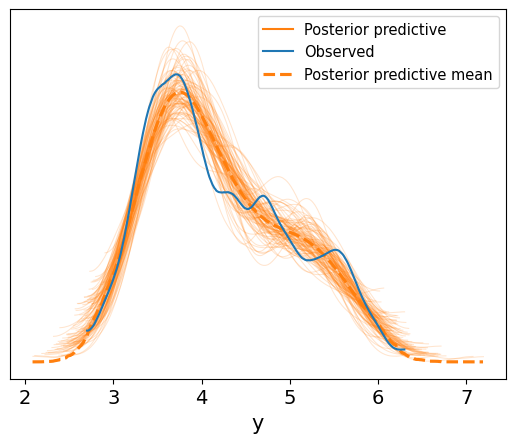

In [32]:
pm.sample_posterior_predictive(idata_penguin,BARTpenguin, extend_inferencedata=True)
az.plot_ppc(idata_penguin, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [36]:
posterior_mean = idata_penguin.posterior["μ"]

μ_hdi = az.hdi(ary=idata_penguin, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(idata_penguin, group="posterior_predictive", var_names=["y"]).T


/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


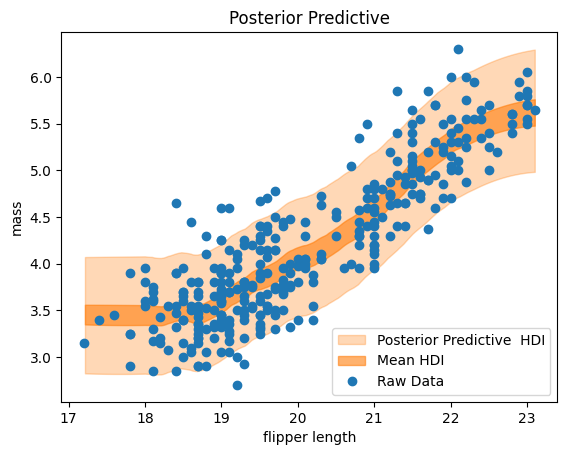

In [44]:
idx = np.argsort(X.iloc[:, 2])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.iloc[:, 2],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive  HDI"},)
az.plot_hdi(
    x=X.iloc[:, 2],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper length",
    ylabel="mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

The plot shows a positive relationship between flipper length and body mass that is roughly linear. The plot doesn't suggest a completely linear relationship, however, and this makes sense if one assumes that there are minimum and maximum quantities of body mass that a penguin needs to have to remain viable. At the same time those limitations do not appear for flipper length because outlier flipper length in either direction is unlikely to impact the viability of a penguin in a significant way.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='bill_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='flipper_length'>], dtype=object)

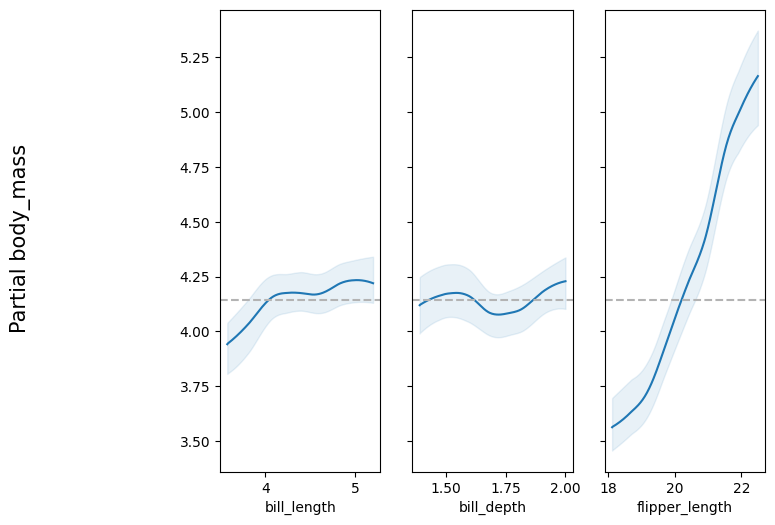

In [45]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='bill_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='flipper_length'>], dtype=object)

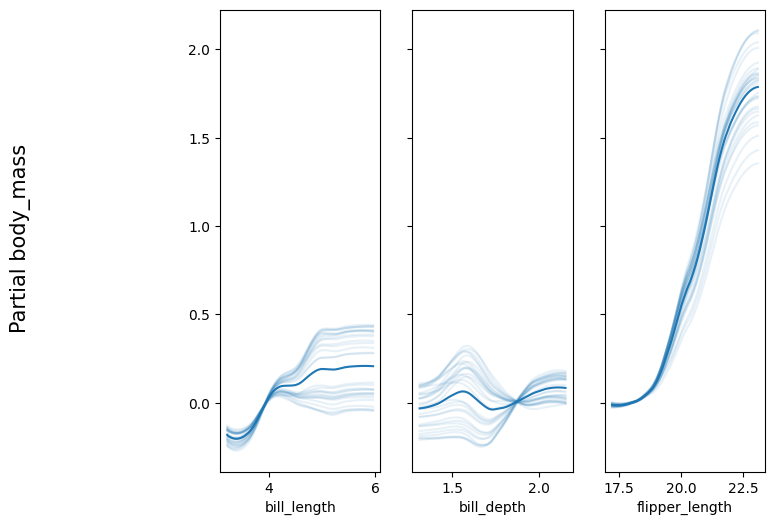

In [46]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In [47]:
vi_ponglins = pmb.compute_variable_importance(idata_penguin, μ_, X)

<Axes: ylabel='R²'>

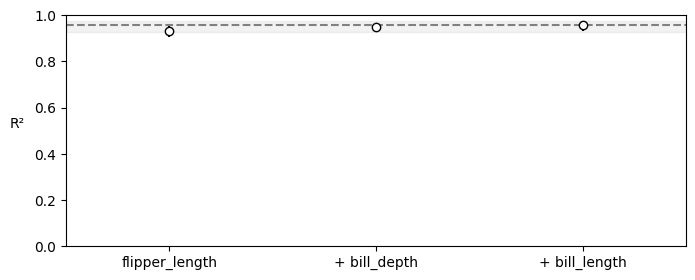

In [48]:
pmb.plot_variable_importance(vi_ponglins)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

The pdp plots show clear positive and linear relationships between flipper length and body mass while the dimentions of penguin bills appear to have more random relationships with the body mass of penguins. The vi plotshows that the improvements to adding the bill dimention data is similarity negligable in comparison to the flipper length impact. The Ice plots suggest that there are not very large interactions between the variables since the lines appear roughly parallel throughout. That is except for 1 point in which bill depth converges. This convertion looks weird and I am not sure if it is caused by interactions in the data or a mistake on my part. I will assume it is because there is an interaction between bill depth and length since the ratios of the dimentions of penguin bills are likely limited through penguin developement.